
진료 과정에서 의사 결정을 할 때 귀납적 성격을 가지고 진단을 내리게 된다고 한다.
귀납적으로 환자로부터 얻은 데이터를 바탕으로 공통의 특성을 파악해서 
일반화된 정보들을 바탕으로 환자의 증상들을 통해 질병을 진단해나간다고 한다.
이를 생각했을 때 주어진 goal_set data들에 있는 환자들이 응답한 증상들을 통해
진단한 질병들에 대한 정보를 중심으로 증상과 질병 사이에 관계를 통해
정보를 일반화하며 학습하면 될 것 같다고 생각이 든다.
-> 그래서 학습 시킬 때 각 환자가 응답한 증상들의 set을 만들고 해당 set들을 가질 수 있는
질병들과 매핑하고 확률 분포, 연관성을 알아보면 좋을 것 같다.(질병과 증상 간의 관계에 대한 학술 자료 같은 것들은 발견은 못하고 블로그에 정리 되어 있는 내용을 가져오게 되었다.)
(https://blog.naver.com/vae3085/220654592114)

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

goal_set = pickle.load(open('../synthetic_dataset/goal_set.p', 'rb'))

In [2]:
train_data = goal_set['train']
test_data = goal_set['test']
validate_data = goal_set['validate']

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
validate_df = pd.DataFrame(validate_data)

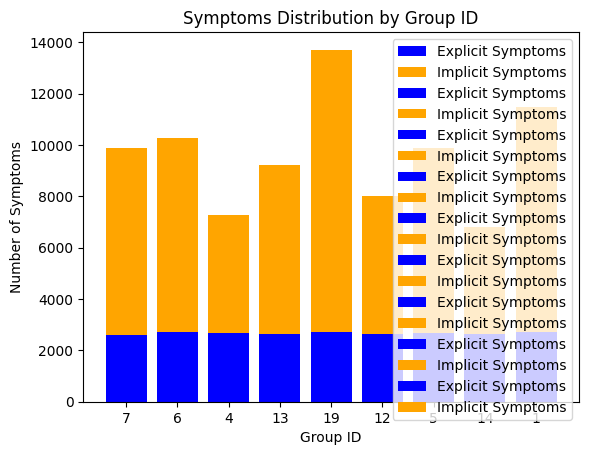

In [3]:
group_symptoms_counts = defaultdict(dict)

# 데이터셋에서 각 group_id별로 증상들의 수를 세기
for data in train_data:
    group_id = data['group_id']
    explicit_inform_slots = data['goal']['explicit_inform_slots']
    implicit_inform_slots = data['goal']['implicit_inform_slots']

    # 해당 group_id별로 explicit_inform_slots 및 implicit_inform_slots의 수를 저장
    total_explicit = len(explicit_inform_slots)
    total_implicit = len(implicit_inform_slots)

    # 딕셔너리에 저장
    group_symptoms_counts[group_id]['explicit'] = group_symptoms_counts[group_id].get('explicit', 0) + total_explicit
    group_symptoms_counts[group_id]['implicit'] = group_symptoms_counts[group_id].get('implicit', 0) + total_implicit

# 그래프 그리기
for group_id, counts in group_symptoms_counts.items():
    plt.bar(group_id, counts['explicit'], color='blue', label='Explicit Symptoms')
    plt.bar(group_id, counts['implicit'], color='orange', bottom=counts['explicit'], label='Implicit Symptoms')
    
plt.xlabel('Group ID')
plt.ylabel('Number of Symptoms')
plt.title('Symptoms Distribution by Group ID')
plt.legend()
plt.show()

각 group_id에 나타난 증상들의 수를 봤을 때 크게 많은 차이가 나는 부분이 없는 것 같다. 데이터를 훈련할 때 하나의 group이 과도하게 학습이 되는 경우는 없을 것으로 보인다.

In [4]:
data_explicit_implicit = [(data['goal']['explicit_inform_slots'], data['goal']['implicit_inform_slots']) for data in train_data]

# explicit_inform_slots와 그에 해당하는 implicit_inform_slots의 확률 분포 계산
explicit_to_implicit_distribution = defaultdict(lambda: defaultdict(int))

for explicit_slots, implicit_slots in data_explicit_implicit:
    for explicit_slot in explicit_slots:
        for implicit_slot in implicit_slots:
            # explicit_inform_slots에 해당하는 implicit_inform_slots의 출현 횟수 증가
            explicit_to_implicit_distribution[explicit_slot][implicit_slot] += 1

# explicit_inform_slots와 그에 해당하는 implicit_inform_slots의 확률 분포 정규화
for explicit_slot, implicit_distribution in explicit_to_implicit_distribution.items():
    total_count = sum(implicit_distribution.values())
    for implicit_slot in implicit_distribution:
        explicit_to_implicit_distribution[explicit_slot][implicit_slot] /= total_count

# 결과를 DataFrame으로 변환
data_list = []

for explicit_slot, implicit_distribution in explicit_to_implicit_distribution.items():
    for implicit_slot, probability in implicit_distribution.items():
        data_list.append({'Explicit Slot': explicit_slot, 'Implicit Slot': implicit_slot, 'Probability': probability})

df = pd.DataFrame(data_list)
df

,Explicit Slot,Implicit Slot,Probability
0,Spots or clouds in vision,Diminished vision,0.285714
1,Spots or clouds in vision,Symptoms of eye,0.120635
2,Spots or clouds in vision,Pain in eye,0.165079
3,Spots or clouds in vision,Foreign body sensation in eye,0.047619
4,Spots or clouds in vision,White discharge from eye,0.009524
...,...,...,...
5769,Pus in urine,Low self-esteem,0.250000
5770,Pus in urine,Disturbance of memory,0.250000
5771,Unusual color or odor to urine,Fatigue,0.333333
5772,Unusual color or odor to urine,Shortness of breath,0.333333


In [5]:
symptom_disease_mapping = {}
for entry in train_data:
    disease_tag = entry['disease_tag']
    explicit_inform_slots = entry['goal']['explicit_inform_slots']
    for symptom in explicit_inform_slots:
        if symptom not in symptom_disease_mapping:
            symptom_disease_mapping[symptom] = []
        symptom_disease_mapping[symptom].append(disease_tag)

# 각 질병에 속해 있는 증상들의 확률 분포를 나타내는 disease_symptom_distribution
def calculate_symptom_distribution(data, disease_tag):
    symptom_counts = Counter()
    total_count = 0
    
    for entry in data:
        if entry['disease_tag'] == disease_tag:
            explicit_inform_slots = entry['goal']['explicit_inform_slots']
            implicit_inform_slots = entry['goal']['implicit_inform_slots']
            
            # explicit_inform_slots의 증상들의 빈도수 계산
            for symptom in explicit_inform_slots:
                symptom_counts[symptom] += 1
                total_count += 1
            
            # implicit_inform_slots의 증상들의 빈도수 계산
            for symptom in implicit_inform_slots:
                symptom_counts[symptom] += 1
                total_count += 1
    
    # 증상들의 빈도수를 전체 등장 횟수로 나누어 확률 분포 계산
    symptom_distribution = {symptom: 100*count / total_count for symptom, count in symptom_counts.items()}
    
    return symptom_distribution

# 각 질병별로 증상들의 확률 분포 계산
disease_symptom_distribution = {}
for entry in train_data:
    disease_tag = entry['disease_tag']
    disease_symptom_distribution[disease_tag] = calculate_symptom_distribution(train_data, disease_tag)

# 각 증상이 해당 질병에만 속하는지 판별한 결과를 가지고 있는 symptom_unique_mapping
symptom_unique_mapping = {}
for symptom, diseases in symptom_disease_mapping.items():
    symptom_unique_mapping[symptom] = {}
    for disease in diseases:
        symptom_unique_mapping[symptom][disease] = len(symptom_disease_mapping[symptom]) == 1

# DataFrame으로 변환
df_data = {
    'Symptom': [],
    'Disease': [],
    'Frequency': [],
    'Unique': []
}

for symptom, diseases in symptom_disease_mapping.items():
    for disease in diseases:
        frequency = disease_symptom_distribution[disease][symptom]
        unique = symptom_unique_mapping[symptom][disease]
        df_data['Symptom'].append(symptom)
        df_data['Disease'].append(disease)
        df_data['Frequency'].append(frequency)
        df_data['Unique'].append(unique)

df = pd.DataFrame(df_data)
df

,Symptom,Disease,Frequency,Unique
0,Spots or clouds in vision,Central retinal artery or vein occlusion,11.795544,False
1,Spots or clouds in vision,Corneal disorder,9.284952,False
2,Spots or clouds in vision,Ectropion,5.788712,False
3,Spots or clouds in vision,Diabetic retinopathy,11.094453,False
4,Spots or clouds in vision,Ectropion,5.788712,False
...,...,...,...,...
23995,Muscle stiffness or tightness,Cerebral edema,3.504482,False
23996,Nose deformity,Acne,0.801282,False
23997,Nose deformity,Acne,0.801282,False
23998,Pus in urine,Dissociative disorder,0.223464,True


각 증상마다 특정 질병에만 나타나는 경우가 많음을 고려하여 unique 정도를 증상들에 따른 질병 판단시 유효한 데이터로 사용할 수 있다고 판딘.

빈도수를 통한 확률 분포를 통해서 다음으로 확인해볼 증상이나 질병들을 판단하는데 도움이 될 거라고 생각이 들었다.

각 증상들과 연관된 질병들, 그리고 그 질병에 대한 해당 증상의 확률 분포, 유니크함(특정 질병에만 존재하는 증상)을 하나의 데이터프레임으로 만들어 봄.

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 주어진 데이터프레임
# df: Symptom, Disease, Frequency, Unique 컬럼을 가진 데이터프레임

# 입력 데이터 및 타겟 데이터 준비
X = df[['Symptom', 'Disease']]
y = df['Frequency']

# 범주형 데이터를 정수로 변환
label_encoder = LabelEncoder()
X['Symptom'] = label_encoder.fit_transform(X['Symptom'])
X['Disease'] = label_encoder.fit_transform(X['Disease'])
y = label_encoder.fit_transform(y)  # 타겟 변수를 정수로 변환

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = XGBClassifier()
model.fit(X_train, y_train)

# 테스트 데이터에서 explicit_inform_slots와 implicit_inform_slots 추출 및 변환
# test_data: explicit_inform_slots와 implicit_inform_slots가 주어진 데이터
# 이 예제에서는 explicit_inform_slots와 implicit_inform_slots를 조합하여 Symptom으로 간주하고 있으므로 이를 정수로 변환합니다.
X_test_explicit = test_data['explicit_inform_slots']
X_test_implicit = test_data['implicit_inform_slots']

X_test_explicit['Symptom'] = label_encoder.transform(X_test_explicit['Symptom'])
X_test_implicit['Symptom'] = label_encoder.transform(X_test_implicit['Symptom'])

# 모델을 사용하여 질병 예측
y_pred = model.predict(X_test)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/var/folders/2_/hntkh91166967hkkcp15mh880000gn/T/ipykernel_18536/1386054906.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Symptom'] = label_encoder.fit_transform(X['Symptom'])
/var/folders/2_/hntkh91166967hkkcp15mh880000gn/T/ipykernel_18536/1386054906.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Disease'] = label_encoder.fit_transform(X['Disease'])


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503
 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521
 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539
 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557
 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575
 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593
 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609 610 611
 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629
 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647
 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665
 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683
 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701
 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755
 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773
 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863
 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881
 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899
 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917
 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935
 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953
 954 955 956 957 958 959 960 961 962 963 964 965], got [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399
 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417
 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435
 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453
 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471
 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489
 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561
 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579
 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597
 598 599 600 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615
 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633
 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651
 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669
 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687
 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705
 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723
 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741
 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759
 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777
 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795
 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813
 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831
 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849
 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867
 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885
 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903
 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921
 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939
 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957
 958 959 960 961 962 963 964 965 966 967 968 969]

- 질병을 진단해 가는 과정에 대한 자료를 보고 귀납적으로 환자의 증상을 물어가면서 가장 확률이 높은 질병을 찾아가는 과정을 생각했을 때 이진트리 기반으로 하되 xgboost 같은 경우에 이진트리로 정답을 찾아가면서 정답이 틀린 경우 더 나은 트리를 찾아가는 과정을 하는 모델이라고 이해해서 특정 증상이 주어졌을 때 또다른 증상들에 대한 응답을 받으면서 가장 정확한 질병을 예측할 수 있다고 생각해서 xgboost에 학습을 시키려고 해보았다.

- xgboost를 통해 학습을 진행하면서 아직 오류들을 해결하지 못한 상황이다. 주로 오류들로는 모델이 원하는 데이터 타입과 셋이 되지 않아서 많이 나타났던 것 같다.